Bibliography:

https://realpython.com/k-means-clustering-python/

## 1)  Import packages

In [4]:
import os
import pandas as pd
import numpy as np
from math import ceil
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
#from kneed import KneeLocator
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

## 2) Import  data

Import the sas table to a pandas dataframe 

In [5]:
dataset = pd.read_sas('../data/a2z_insurance.sas7bdat')

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustID         10296 non-null  float64
 1   FirstPolYear   10266 non-null  float64
 2   BirthYear      10279 non-null  float64
 3   EducDeg        10279 non-null  object 
 4   MonthSal       10260 non-null  float64
 5   GeoLivArea     10295 non-null  float64
 6   Children       10275 non-null  float64
 7   CustMonVal     10296 non-null  float64
 8   ClaimsRate     10296 non-null  float64
 9   PremMotor      10262 non-null  float64
 10  PremHousehold  10296 non-null  float64
 11  PremHealth     10253 non-null  float64
 12  PremLife       10192 non-null  float64
 13  PremWork       10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [7]:
dataset.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [8]:
dataset.shape

(10296, 14)

We have 10k observations available and 14 variables

Check for duplicated rows

In [9]:
dataset.duplicated().sum()

0

We don't have any duplicates

Lets drop customer ID

In [10]:
dataset.drop('CustID', axis=1, inplace=True)

In [11]:
dataset.duplicated().sum()

3

If we dont consider the CustID we have 3 identical rows. Could this be the same client with different client numbers?
Lets drop these rows

In [12]:
dataset.drop_duplicates(inplace=True)

In [13]:
dataset.shape

(10293, 13)

## Data Exploration

In [14]:
## create a new dataset to maintain the original
data_exp = dataset.copy()

In [15]:
## Variables that will allow me to explore my data: client tenure and client age
data_exp['ClientTenure'] = 2016-data_exp['FirstPolYear']
data_exp['ClientAge'] = 2016-data_exp['BirthYear']

In [16]:
## drop the columns 
data_exp.drop(columns=['FirstPolYear','BirthYear'], inplace=True)

In [17]:
data_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10257.0,2506.618699,1157.518390,333.00,1706.00,2502.00,3290.00,55215.00
GeoLivArea,10292.0,2.709483,1.266284,1.00,1.00,3.00,4.00,4.00
Children,10272.0,0.706776,0.455263,0.00,0.00,1.00,1.00,1.00
CustMonVal,10293.0,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,0.742728,2.917385,0.00,0.39,0.72,0.98,256.20
PremMotor,10259.0,300.501550,211.937740,-4.11,190.59,298.61,408.30,11604.42
PremHousehold,10293.0,210.419863,352.635041,-75.00,49.45,132.80,290.05,25048.80
PremHealth,10250.0,171.553183,296.444399,-2.11,111.80,162.81,219.04,28272.00
PremLife,10189.0,41.848724,47.484264,-7.00,9.89,25.56,57.79,398.30
PremWork,10207.0,41.283712,51.519022,-12.00,10.67,25.67,56.79,1988.70


- Age has a max of 988 years
- Client tenure has a min of -51 768 yrs
- Someone earns 55k per month
- There are clients with negative premiums
- 1 client has 256% of claim rate = a really bad client
- ~71% of the clients have children

In [18]:
data_exp.isna().sum()

EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
ClientTenure      30
ClientAge         17
dtype: int64

There are some nulls for the premium variables. We're going to explore these ones now and the rest analyse further ahead.

I know that there are clients with negative premiums and this may mean they canceled a policy in the previous year. Because I dont know all the others if they canceled or not I will put these values to zero

In [19]:
# replaces negative values for zeros
data_exp['PremMotor'] = np.where(data_exp['PremMotor']<0,0,data_exp['PremMotor'])
data_exp['PremHousehold'] = np.where(data_exp['PremHousehold']<0,0,data_exp['PremHousehold'])
data_exp['PremHealth'] = np.where(data_exp['PremHealth']<0,0,data_exp['PremHealth'])
data_exp['PremLife'] = np.where(data_exp['PremLife']<0,0,data_exp['PremLife'])
data_exp['PremWork'] = np.where(data_exp['PremWork']<0,0,data_exp['PremWork'])

# will consider that premiums missing is because client does not own the product
data_exp['PremMotor'].fillna(0, inplace=True)
data_exp['PremHousehold'].fillna(0, inplace=True)
data_exp['PremHealth'].fillna(0, inplace=True)
data_exp['PremLife'].fillna(0, inplace=True)
data_exp['PremWork'].fillna(0, inplace=True)

In [20]:
data_exp.isna().sum()

EducDeg          17
MonthSal         36
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
ClientTenure     30
ClientAge        17
dtype: int64

Before we start analyzing the data lets have a first look to the correlations. This will allow me to understand each variables I will use of not in my segmentation and will influence if I need to treat them or not. Will also allow me to understand maybe the dimensions I want to use in my segmentation (not too correlated but not completly independent)

In [21]:
metric_features = ['MonthSal','CustMonVal','ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork','ClientTenure','ClientAge']
class_features = ['GeoLivArea','Children']

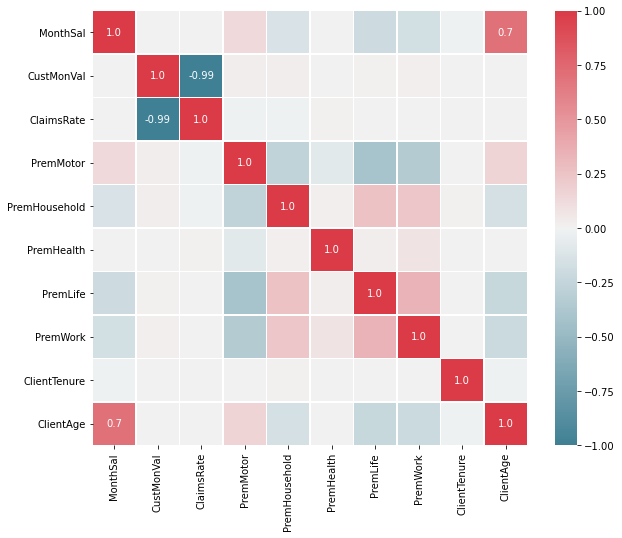

In [22]:
# builds correlation matrix
corre = round(data_exp[metric_features].corr(),2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corre.values) >= 0.5
annot = np.where(mask_annot, corre.values, np.full(corre.shape,"")) # Try to understand what this np.where() does

# Prepare figure
fig = plt.figure(figsize=(10, 8))
# Plot heatmap of the correlation matrix
sns.heatmap(data=corre, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

plt.show()

The data does not have strong correlations. Client age and Monthly salary are obviously correlated but we will still keep both. Claims rate and customer value have a perfect correlation. It is way more intuitive to use claims cost (claims rate x total premiums) in the segmentation than CustMonVal (complex calculation).

In [23]:
## check the matrix
corre

,MonthSal,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
MonthSal,1.00,-0.00,-0.00,0.14,-0.13,-0.00,-0.20,-0.17,-0.01,0.70
CustMonVal,-0.00,1.00,-0.99,0.03,0.03,0.00,0.01,0.02,-0.00,-0.00
ClaimsRate,-0.00,-0.99,1.00,-0.01,-0.01,0.01,0.00,-0.00,0.00,-0.00
PremMotor,0.14,0.03,-0.01,1.00,-0.27,-0.08,-0.41,-0.34,-0.00,0.16
PremHousehold,-0.13,0.03,-0.01,-0.27,1.00,0.02,0.26,0.24,0.01,-0.15
PremHealth,-0.00,0.00,0.01,-0.08,0.02,1.00,0.03,0.08,-0.00,-0.00
PremLife,-0.20,0.01,0.00,-0.41,0.26,0.03,1.00,0.34,0.00,-0.23
PremWork,-0.17,0.02,-0.00,-0.34,0.24,0.08,0.34,1.00,0.00,-0.21
ClientTenure,-0.01,-0.00,0.00,-0.00,0.01,-0.00,0.00,0.00,1.00,-0.01
ClientAge,0.70,-0.00,-0.00,0.16,-0.15,-0.00,-0.23,-0.21,-0.01,1.00


In [24]:
data_exp.drop(['CustMonVal'], axis=1, inplace=True)

In [25]:
# # Prepare figure. Create individual axes where each histogram will be placed
# fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# # Plot data
# # Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
# for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
#     ax.hist(data_exp[feat])
#     ax.set_title(feat, y=-0.13)
    
# # Layout
# # Add a centered title to the figure:
# title = "Numeric Variables' Histograms"

# plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
# plt.show()

The dataset has a lot of outliers. Lets do one at the time to analyze.

In [26]:
data_exp[data_exp['ClientTenure']==-51768]

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
9294,b'3 - BSc/MSc',3268.0,1.0,0.0,0.37,351.4,15.0,187.37,22.45,17.78,-51768.0,68.0


In [27]:
# because its only strange value for this variable and for this client, I will assume is an error and will be NaN
data_exp['ClientTenure'].replace(-51768, None, inplace=True)

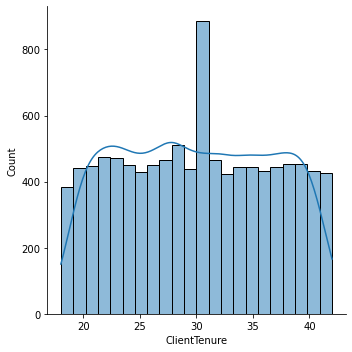

In [28]:
##plot client tenure
sns.displot(data= data_exp, x='ClientTenure', kde=True)
plt.show()

## there is a even distribution of tenures with a spik at 30 years of tenure. I would expect a more normal distribution

In [29]:
data_exp[data_exp['ClientAge']==988]

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
7195,b'3 - BSc/MSc',2830.0,4.0,0.0,0.77,428.97,192.8,108.91,1.89,23.67,23.0,988.0


In [30]:
# same logic as ClientTenure here for ClientAge
data_exp['ClientAge'].replace(988, None, inplace=True)

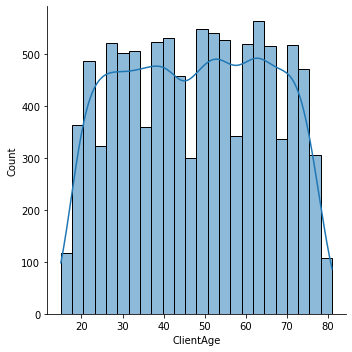

In [31]:
##plot client tenure
sns.displot(data= data_exp, x='ClientAge', kde=True)
plt.show()

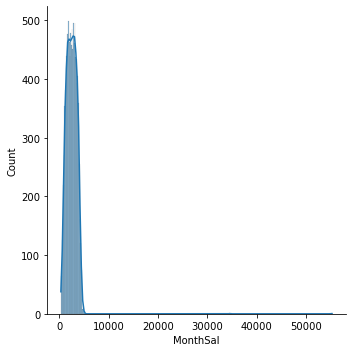

In [32]:
# Plot Monthly Salary

sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

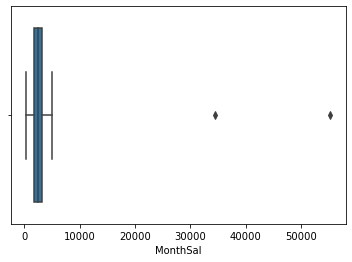

In [33]:
sns.boxplot(data= data_exp, x='MonthSal')
plt.show()

In [34]:
# Filter clients with a montly salary higher or equal to 3k - not losing the missings
data_exp = data_exp[(data_exp['MonthSal']<30000) | (data_exp['MonthSal'].isna())]

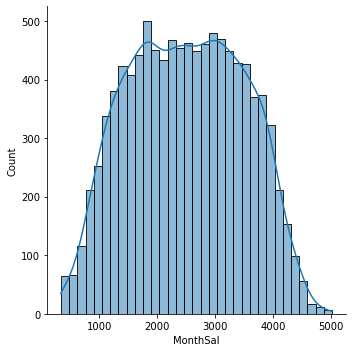

In [35]:
##plot monthly salary
sns.displot(data= data_exp, x='MonthSal', kde=True)
plt.show()

In [36]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.95 of the original data


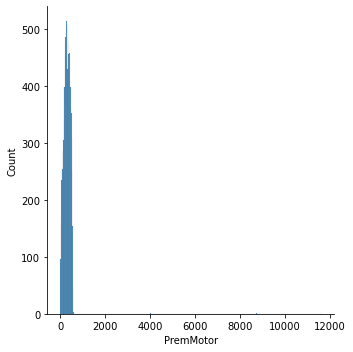

In [37]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'])
plt.show()

As we saw there is a client with 12k motor premium. Lets remove the client

In [38]:
# how many clients have a premium higher than 2k ?
data_exp[data_exp['PremMotor']>=2000] #7

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
5128,b'1 - Basic',3763.0,1.0,0.0,0.90,4003.44,612.9,137.36,121.69,31.34,20.0,73.0
5211,b'2 - High School',4135.0,3.0,0.0,0.99,8744.61,101.7,1767.00,155.14,130.58,35.0,73.0
5293,b'3 - BSc/MSc',3564.0,3.0,1.0,0.09,11604.42,48.9,1045.52,103.13,296.47,27.0,53.0
6701,b'3 - BSc/MSc',2947.0,4.0,0.0,0.03,4273.49,83.9,105.13,3.00,3.89,21.0,65.0
7085,b'3 - BSc/MSc',2460.0,3.0,1.0,0.01,5645.50,0.0,49.01,1.89,1.89,24.0,53.0
7904,b'3 - BSc/MSc',2354.0,4.0,1.0,1.01,3106.62,30.0,59.01,12.89,9.00,42.0,57.0


In [39]:
# Filter clients with a motor premium higher or equal to 2k
data_exp = data_exp[data_exp['PremMotor']<2000]

In [40]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.89 of the original data


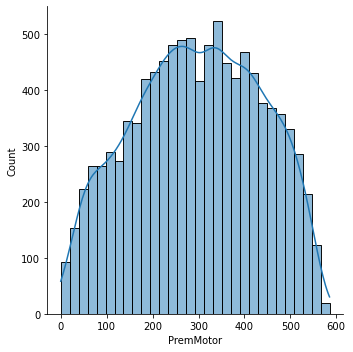

In [41]:
# Motor Premims
sns.displot(data=data_exp, x=data_exp['PremMotor'], kde=True)
plt.show()

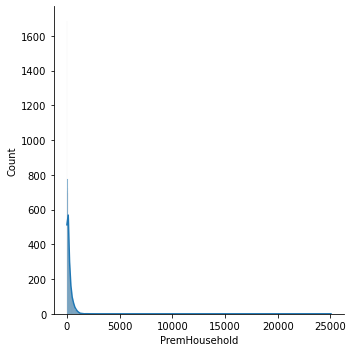

In [42]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

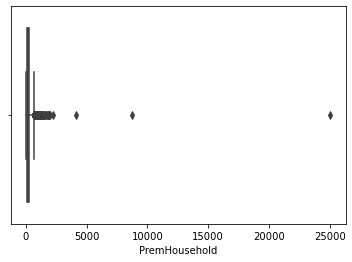

In [43]:
sns.boxplot(data= data_exp, x='PremHousehold')
plt.show()

In [44]:
# how many clients have a premium higher than 4k ?
data_exp[data_exp['PremHousehold']>=4000] #3

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
6343,b'2 - High School',2642.0,2.0,1.0,0.99,424.19,4130.7,118.69,15.67,41.45,35.0,67.0
6835,b'3 - BSc/MSc',2832.0,4.0,1.0,1.00,535.10,8762.8,41.12,0.00,9.78,41.0,50.0
8866,b'2 - High School',2618.0,4.0,1.0,0.98,508.43,25048.8,36.23,9.89,11.89,38.0,44.0


In [45]:
# Filter clients with a home premium higher or equal to 4k
data_exp = data_exp[data_exp['PremHousehold']<4000]

In [46]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.86 of the original data


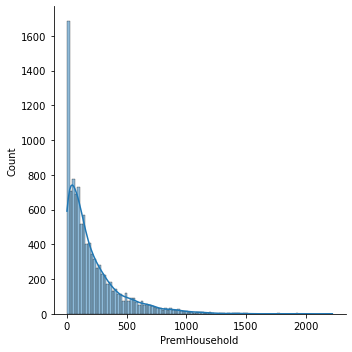

In [47]:
# Home Premims
sns.displot(data=data_exp, x=data_exp['PremHousehold'], kde=True)
plt.show()

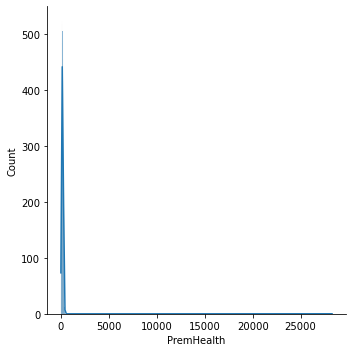

In [48]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

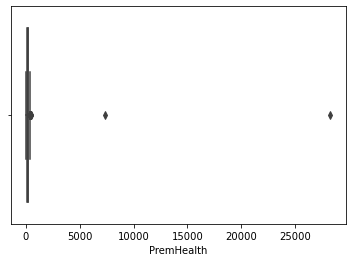

In [49]:
sns.boxplot(data= data_exp, x='PremHealth')
plt.show()

In [50]:
data_exp[data_exp['PremHealth']>5000]

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
7961,b'3 - BSc/MSc',4002.0,3.0,0.0,0.83,431.86,107.80,7322.48,12.89,930.44,21.0,74.0
9149,b'2 - High School',987.0,3.0,1.0,0.97,26.34,829.05,28272.00,65.68,138.25,31.0,22.0


In [51]:
data_exp = data_exp[data_exp['PremHealth']<5000]

In [52]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.84 of the original data


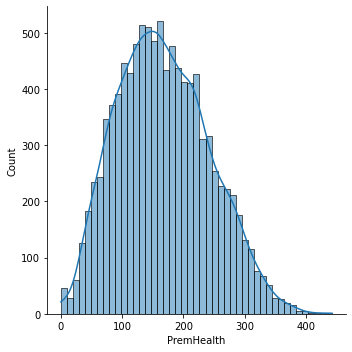

In [53]:
# Health Premims
sns.displot(data=data_exp, x=data_exp['PremHealth'], kde=True)
plt.show()

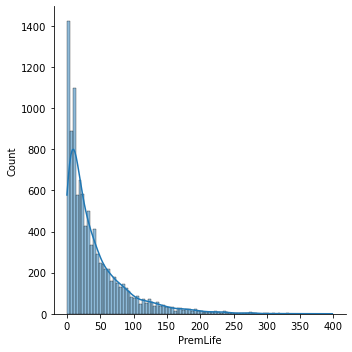

In [54]:
# Life Premims
sns.displot(data=data_exp, x=data_exp['PremLife'], kde=True)
plt.show()

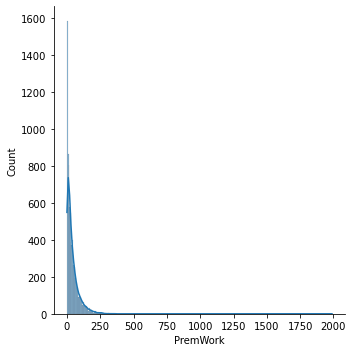

In [55]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

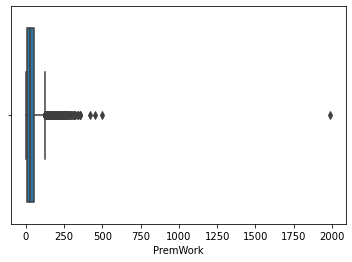

In [56]:
sns.boxplot(data= data_exp, x='PremWork')
plt.show()

In [57]:
data_exp[data_exp['PremWork']>500]

,EducDeg,MonthSal,GeoLivArea,Children,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge
5084,b'2 - High School',3330.0,3.0,0.0,0.14,350.51,201.7,125.8,39.23,1988.7,22.0,57.0


In [58]:
data_exp = data_exp[data_exp['PremWork']<500]

In [59]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.83 of the original data


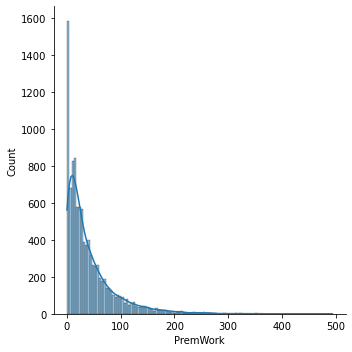

In [60]:
# Wokers Comp Premims
sns.displot(data=data_exp, x=data_exp['PremWork'], kde=True)
plt.show()

In [61]:
# Creating 2 new variables
data_exp['TotalPremiums'] = data_exp['PremMotor']+data_exp['PremHousehold']+data_exp['PremHealth']+data_exp['PremLife']+data_exp['PremWork']
data_exp['ClaimsCost'] = data_exp['ClaimsRate'] * data_exp['TotalPremiums']

In [62]:
data_exp.drop('ClaimsRate', axis=1, inplace=True)

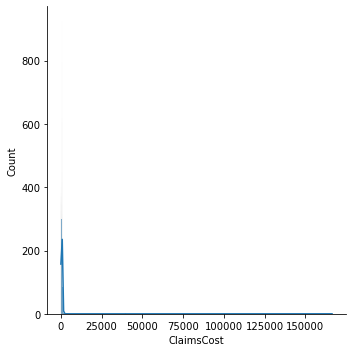

In [63]:
##plot claims cost
sns.displot(data= data_exp, x='ClaimsCost', kde=True)
plt.show()

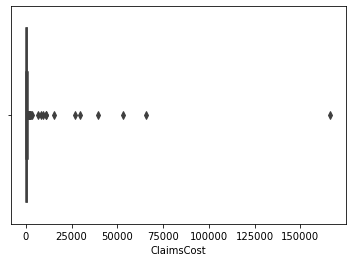

In [64]:
sns.boxplot(data= data_exp, x='ClaimsCost')
plt.show()

In [65]:
data_exp[data_exp['ClaimsCost']>2000]

,EducDeg,MonthSal,GeoLivArea,Children,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalPremiums,ClaimsCost
51,b'3 - BSc/MSc',3234.0,4.0,1.0,557.44,20.00,29.56,5.00,0.00,34.0,50.0,612.00,15520.3200
112,b'4 - PhD',2354.0,1.0,1.0,518.32,4.45,55.90,3.89,10.89,19.0,37.0,593.45,9287.4925
135,b'3 - BSc/MSc',2176.0,4.0,1.0,297.61,162.80,143.36,136.47,0.00,19.0,28.0,740.24,10955.5520
171,b'3 - BSc/MSc',1086.0,4.0,1.0,378.07,78.90,166.81,6.89,18.45,26.0,27.0,649.12,166304.5440
655,b'3 - BSc/MSc',3279.0,3.0,1.0,410.30,117.25,95.35,37.34,22.56,42.0,53.0,682.80,65548.8000
675,b'2 - High School',4435.0,1.0,0.0,197.48,280.60,276.94,51.12,38.34,22.0,79.0,844.48,53202.2400
707,b'3 - BSc/MSc',1634.0,1.0,1.0,175.70,319.50,294.39,44.12,16.89,25.0,25.0,850.60,29771.0000
758,b'3 - BSc/MSc',1117.0,1.0,1.0,193.37,342.85,276.94,8.78,47.23,28.0,24.0,869.17,10951.5420
793,b'3 - BSc/MSc',1370.0,3.0,1.0,127.58,48.35,398.41,19.56,12.78,36.0,33.0,606.68,8432.8520
917,b'2 - High School',3355.0,4.0,0.0,135.58,290.05,221.82,86.46,100.13,30.0,64.0,834.04,26939.4920


These are clients that cost to the company way more than they pay in premiums. I will exclude them as outliers but these my be a segment on their own.

In [66]:
data_exp = data_exp[data_exp['ClaimsCost']<=2000]

In [67]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.68 of the original data


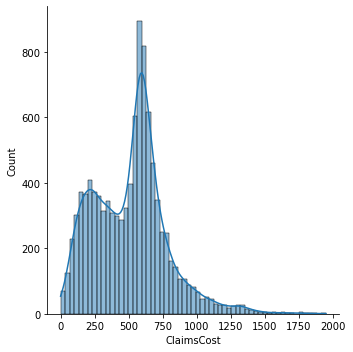

In [68]:
##plot claims cost
sns.displot(data= data_exp, x='ClaimsCost', kde=True)
plt.show()

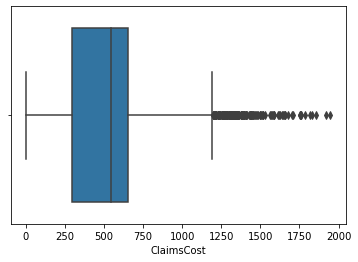

In [69]:
sns.boxplot(data= data_exp, x='ClaimsCost')
plt.show()

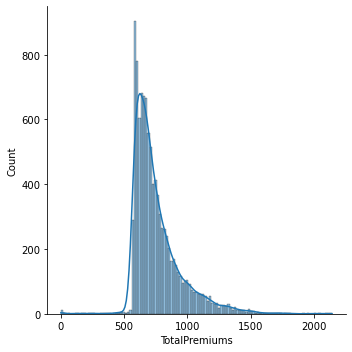

In [70]:
##plot Total premiums
sns.displot(data= data_exp, x='TotalPremiums', kde=True)
plt.show()

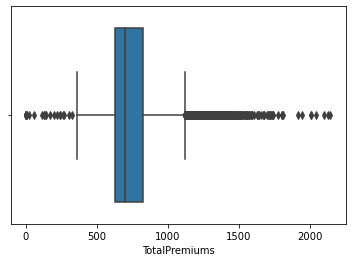

In [71]:
sns.boxplot(data= data_exp, x='TotalPremiums')
plt.show()

About the categorical variables we are not going to use them in the segmentation since computing distances with these variables will be meaningful. But we will use them to interpret the results and maybe missing imputation.

## 3) Data preprocessing

Let's take a look again at the data

In [72]:
data_exp.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthSal,10227.0,2498.144031,984.038381,333.0,1706.0000,2501.000,3290.00000,5021.0000
GeoLivArea,10262.0,2.708829,1.266697,1.0,1.0000,3.000,4.00000,4.0000
Children,10242.0,0.706796,0.455254,0.0,0.0000,1.000,1.00000,1.0000
PremMotor,10263.0,296.069312,138.855520,0.0,190.2600,298.390,407.41000,585.2200
PremHousehold,10263.0,209.602952,231.970311,0.0,49.4500,132.800,290.05000,1957.6000
PremHealth,10263.0,167.213156,74.780457,0.0,110.9100,162.030,218.93000,442.8600
PremLife,10263.0,41.612681,47.256299,0.0,9.8900,25.450,57.01000,398.3000
PremWork,10263.0,41.035402,46.461469,0.0,10.0000,25.560,56.01000,494.1000
ClientTenure,10233.0,29.985928,6.609160,18.0,24.0000,30.000,36.00000,42.0000
ClientAge,10246.0,47.900059,17.388035,15.0,33.0000,48.000,63.00000,81.0000


In [73]:
# Creating a new dataframe
data_prep = data_exp.copy()

<b> Validate the data </b>

In [74]:
# Clients where the client tenure is higher than their age
len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])

1991

In [75]:
len(data_prep.loc[data_prep['ClientTenure']>data_prep['ClientAge']])/len(data_prep)

0.1939978563772776

~2k clients have a policy that is older than them. It represents 20% of the data 

Minimum age was 15, let's look at clients that are underage. It is not very normal to have clients so young with insurance.

In [76]:
data_prep.loc[data_prep['ClientAge']<18].T

,13,186,397,480,526,620,659,689,865,893,...,9557,9636,9650,9678,9906,9936,9947,10043,10121,10290
EducDeg,b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',...,b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic'
MonthSal,1043.0,1247.0,415.0,1581.0,840.0,578.0,1284.0,1180.0,562.0,698.0,...,808.0,1001.0,1041.0,608.0,1422.0,918.0,422.0,1110.0,738.0,626.0
GeoLivArea,3.0,2.0,1.0,4.0,4.0,1.0,4.0,3.0,1.0,4.0,...,3.0,4.0,4.0,2.0,1.0,3.0,1.0,1.0,4.0,3.0
Children,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
PremMotor,44.34,33.23,52.01,30.34,132.69,78.46,46.23,54.9,40.34,61.68,...,22.56,43.34,31.45,40.23,69.68,29.45,36.23,25.56,57.12,6.89
PremHousehold,342.85,1026.3,348.4,683.45,165.6,387.3,1079.65,406.2,847.95,323.4,...,1132.45,570.1,136.7,221.15,231.15,457.85,1409.15,1011.85,293.95,878.5
PremHealth,127.69,82.57,49.01,98.13,137.36,193.48,72.68,65.79,94.24,75.46,...,81.46,241.49,220.82,72.68,201.26,117.69,66.68,120.8,100.02,103.13
PremLife,267.94,75.68,193.48,71.68,129.69,141.36,252.27,112.02,178.7,261.16,...,224.93,87.24,239.6,228.82,191.48,275.94,14.78,144.25,276.83,113.02
PremWork,94.46,212.15,225.82,249.16,164.14,82.24,0.0,256.05,112.13,109.13,...,32.45,115.91,56.79,212.04,82.35,78.35,171.59,105.13,96.24,201.26
ClientTenure,33.0,23.0,30.0,32.0,34.0,33.0,25.0,19.0,37.0,38.0,...,28.0,24.0,21.0,22.0,40.0,27.0,29.0,33.0,38.0,22.0


<b> Let's treat the rest of the missing data </b>

In [77]:
data_prep.isna().sum()

EducDeg          17
MonthSal         36
GeoLivArea        1
Children         21
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
ClientTenure     30
ClientAge        17
TotalPremiums     0
ClaimsCost        0
dtype: int64

Creating a predictive model to estimate MonthSal and ClientAge to fill nan <br>
Possible explanatory variables = EducDeg, MonthSal, GeoLivArea, Children


In [78]:
# how many clients have MonthSal and ClientAge missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.ClientAge.isna())]))

0


In [79]:
# how many clients have MonthSal and EducDeg missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.EducDeg.isna())]))
print(len(data_prep[(data_prep.ClientAge.isna()) & (data_prep.EducDeg.isna())]))

1
0


In [80]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.GeoLivArea.isna())]))
print(len(data_prep[(data_prep.ClientAge.isna()) & (data_prep.GeoLivArea.isna())]))

0
0


In [81]:
# how many clients have MonthSal and GeoLivArea missing
print(len(data_prep[(data_prep.MonthSal.isna()) & (data_prep.Children.isna())]))
print(len(data_prep[(data_prep.ClientAge.isna()) & (data_prep.Children.isna())]))

0
0


In [82]:
# theres 1 client with GeoLivArea missing. I will not use this variable in my clusters but I will use to impute the other 
# variables so I will drop it

data_prep.dropna(subset=['EducDeg'], inplace=True)

In [83]:
print('we kept {:.2f} of the original data'.format((len(data_exp)/(len(dataset)+3))*100))

we kept 99.68 of the original data


In [84]:
# Monthly Salary
# I saw already that age is correlated with montly salary but maybe eductation level is too
# what is the average salary by education level
data_prep.groupby('EducDeg')['MonthSal'].median()

EducDeg
b'1 - Basic'          1710.0
b'2 - High School'    2502.0
b'3 - BSc/MSc'        2615.0
b'4 - PhD'            2645.0
Name: MonthSal, dtype: float64

In [85]:
# Indeed we see that higher the education higher the monthly salary
# Also works for living area?
# what is the average salary by education level
data_prep.groupby('GeoLivArea')['MonthSal'].median()

GeoLivArea
1.0    2473.5
2.0    2557.0
3.0    2464.0
4.0    2524.0
Name: MonthSal, dtype: float64

In [86]:
data_prep.groupby('Children')['MonthSal'].median()

Children
0.0    3501.5
1.0    2194.5
Name: MonthSal, dtype: float64

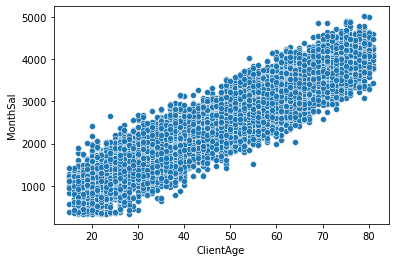

In [87]:
sns.scatterplot(data=data_prep, x='ClientAge',y='MonthSal')
plt.show()

In [88]:
data_prep['Q_ClientAge'] = pd.qcut(data_prep['ClientAge'], q=5)

In [89]:
data_prep.groupby(['EducDeg','Q_ClientAge']).MonthSal.agg('mean')

EducDeg             Q_ClientAge   
b'1 - Basic'        (14.999, 30.0]    1059.674917
                    (30.0, 42.0]      1914.311765
                    (42.0, 54.0]      2500.828025
                    (54.0, 66.0]      3184.720930
                    (66.0, 81.0]      3793.544872
b'2 - High School'  (14.999, 30.0]    1262.051114
                    (30.0, 42.0]      1862.333333
                    (42.0, 54.0]      2579.147059
                    (54.0, 66.0]      3158.959420
                    (66.0, 81.0]      3781.432308
b'3 - BSc/MSc'      (14.999, 30.0]    1380.320644
                    (30.0, 42.0]      1890.275962
                    (42.0, 54.0]      2545.608445
                    (54.0, 66.0]      3158.120038
                    (66.0, 81.0]      3791.919957
b'4 - PhD'          (14.999, 30.0]    1500.392857
                    (30.0, 42.0]      1878.839744
                    (42.0, 54.0]      2514.974522
                    (54.0, 66.0]      3161.193103
               

In [90]:
data_prep.groupby(['EducDeg']).ClientAge.agg('mean')

EducDeg
b'1 - Basic'          38.236780
b'2 - High School'    47.700029
b'3 - BSc/MSc'        50.115063
b'4 - PhD'            51.106475
Name: ClientAge, dtype: float64

In [91]:
# there is ppl with salaries with less than 18 yrs?

data_prep.loc[data_prep['ClientAge']==15].T

,659,689,865,1436,2579,3146,4465,4483,5347,5607,8962,9906
EducDeg,b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic',b'1 - Basic'
MonthSal,1284.0,1180.0,562.0,823.0,1006.0,372.0,958.0,1241.0,1119.0,1131.0,1117.0,1422.0
GeoLivArea,4.0,3.0,1.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,4.0,1.0
Children,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
PremMotor,46.23,54.9,40.34,129.58,48.23,60.68,28.56,43.34,148.14,43.23,19.56,69.68
PremHousehold,1079.65,406.2,847.95,177.8,396.75,270.6,1359.15,589.55,628.45,690.7,1109.1,231.15
PremHealth,72.68,65.79,94.24,58.01,291.5,177.59,68.79,142.47,221.82,157.03,55.9,201.26
PremLife,252.27,112.02,178.7,176.7,127.58,182.48,38.23,121.8,45.12,87.35,230.82,191.48
PremWork,0.0,256.05,112.13,218.15,24.45,107.13,179.59,179.48,30.23,142.25,53.9,82.35
ClientTenure,25.0,19.0,37.0,27.0,30.0,22.0,38.0,33.0,36.0,42.0,38.0,40.0


In [92]:
data_prep.loc[(data_prep['ClientAge']<30) & (data_prep['EducDeg']=='PhD')].T

""
EducDeg
MonthSal
GeoLivArea
Children
PremMotor
PremHousehold
PremHealth
PremLife
PremWork
ClientTenure


In [93]:
# I will try to predict clients monthly salary based on this 4 variables

data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'1 - Basic', 'Basic', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'2 - High School', 'HighSchool', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'3 - BSc/MSc', 'BscMsc', data_prep['EducDeg'])
data_prep['EducDeg'] = np.where(data_prep['EducDeg']==b'4 - PhD', 'PhD', data_prep['EducDeg'])

educ_dummys = pd.get_dummies(data_prep['EducDeg'], prefix='Educ')

In [94]:
educ_dummys.head()

,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,1,0,0
4,0,1,0,0


In [95]:
# I want to change the type to int and for that I need to impute the missing value since ints cannot have nan values
data_prep['GeoLivArea'].fillna(data_prep['GeoLivArea'].mode()[0], inplace=True)
data_prep['GeoLivArea'] = data_prep['GeoLivArea'].astype('int32')
liv_dummys = pd.get_dummies(data_prep['GeoLivArea'], prefix='Liv')

In [96]:
liv_dummys.head()

,Liv_1,Liv_2,Liv_3,Liv_4
0,1,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1


In [97]:
## merge the data
data_prep = pd.concat([data_prep,educ_dummys,liv_dummys], axis=1)
data_prep.head()

,EducDeg,MonthSal,GeoLivArea,Children,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,...,ClaimsCost,Q_ClientAge,Educ_Basic,Educ_BscMsc,Educ_HighSchool,Educ_PhD,Liv_1,Liv_2,Liv_3,Liv_4
0,HighSchool,2177.0,1,1.0,375.85,79.45,146.36,47.01,16.89,31.0,...,259.5684,"(30.0, 42.0]",0,0,1,0,1,0,0,0
1,HighSchool,677.0,4,1.0,77.46,416.20,116.69,194.48,106.13,35.0,...,1020.2752,"(14.999, 30.0]",0,0,1,0,0,0,0,1
2,Basic,2277.0,3,0.0,206.15,224.50,124.58,86.35,99.02,25.0,...,207.3680,"(42.0, 54.0]",1,0,0,0,0,0,1,0
3,BscMsc,1099.0,4,1.0,182.48,43.35,311.17,35.34,28.34,26.0,...,594.6732,"(30.0, 42.0]",0,1,0,0,0,0,0,1
4,BscMsc,1763.0,4,1.0,338.62,47.80,182.59,18.78,41.45,30.0,...,566.3160,"(42.0, 54.0]",0,1,0,0,0,0,0,1


In [98]:
# to train the models I need to take the missings
ms_impute = data_prep.dropna()

In [99]:
# Predictig MonthSal 
features = ['ClientAge','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','Liv_1','Liv_2','Liv_3','Liv_4','Children']
X_train = ms_impute[features]
y_train = ms_impute.MonthSal

In [100]:
DecisionTree = DecisionTreeRegressor().fit(X_train,y_train)

In [101]:
# from sklearn import tree
# plt.figure(figsize=(50,50))
# tree.plot_tree(DecisionTree,feature_names=features, filled=True)
# plt.show()

In [102]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, DecisionTree.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, DecisionTree.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 338.09


In [103]:
LinearRegressor = LinearRegression().fit(X_train,y_train)

In [104]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, LinearRegressor.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, LinearRegressor.predict(X_train))**(1/2))))

R2 Score: 0.86
RMSE: 368.92


In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [106]:
RandomForest = RandomForestRegressor().fit(X_train,y_train)
GradientBoost = GradientBoostingRegressor().fit(X_train,y_train)

In [107]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, RandomForest.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, RandomForest.predict(X_train))**(1/2))))

R2 Score: 0.88
RMSE: 339.42


In [108]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.MonthSal, GradientBoost.predict(X_train))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.MonthSal, GradientBoost.predict(X_train))**(1/2))))

R2 Score: 0.86
RMSE: 364.53


In [109]:
# Can I also predict the clients age?
features2 = ['MonthSal','Educ_Basic','Educ_HighSchool','Educ_BscMsc','Educ_PhD','Liv_1','Liv_2','Liv_3','Liv_4','Children']
X_train2 = ms_impute[features2]
y_train2 = ms_impute.ClientAge

In [110]:
DecisionTree2 = DecisionTreeRegressor().fit(X_train2,y_train2)

In [111]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.ClientAge, DecisionTree2.predict(X_train2))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.ClientAge, DecisionTree2.predict(X_train2))**(1/2))))

R2 Score: 0.99
RMSE: 1.86


In [112]:
RandomForest2 = RandomForestRegressor().fit(X_train2,y_train2)
GradientBoost2 = GradientBoostingRegressor().fit(X_train2,y_train2)

In [113]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.ClientAge, RandomForest2.predict(X_train2))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.ClientAge, RandomForest2.predict(X_train2))**(1/2))))

R2 Score: 0.97
RMSE: 2.87


In [114]:
print('R2 Score: {:.2f}'.format(metrics.r2_score(ms_impute.ClientAge, GradientBoost2.predict(X_train2))))
print('RMSE: {:.2f}'.format((metrics.mean_squared_error(ms_impute.ClientAge, GradientBoost2.predict(X_train2))**(1/2))))

R2 Score: 0.89
RMSE: 5.80


In [115]:
# I have almost no error in the prediction of age

In [116]:
# reset index for row iteration since we already drop some columns
data_prep.reset_index(inplace=True)

In [117]:
for i in range(len(data_prep)):
    if pd.isnull(data_prep.iloc[i]['MonthSal']) == True:
        data_prep['MonthSal'].iloc[i] = DecisionTree.predict(pd.DataFrame(data_prep.iloc[i][features]).T)[0]

C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\bviei\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [118]:
data_exp.loc[(data_exp['MonthSal'].isna()) & (data_exp['EducDeg'] == b'4 - PhD')]

,EducDeg,MonthSal,GeoLivArea,Children,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,ClientAge,TotalPremiums,ClaimsCost
3227,b'4 - PhD',NaN,1.0,0.0,225.6,0.0,0.0,19.56,13.56,26.0,67.0,258.72,225.0864


In [119]:
data_prep.loc[data_prep['index']==3227].T

,3207
index,3227
EducDeg,PhD
MonthSal,3631.375
GeoLivArea,1
Children,0.0
PremMotor,225.6
PremHousehold,0.0
PremHealth,0.0
PremLife,19.56
PremWork,13.56


In [120]:
data_prep.loc[data_prep['index']==21].T

,21
index,21
EducDeg,HighSchool
MonthSal,3277.333333
GeoLivArea,3
Children,1.0
PremMotor,407.52
PremHousehold,111.7
PremHealth,100.13
PremLife,24.67
PremWork,30.34


In [121]:
# Impute Age
#data_prep.iloc[i]['MonthSal'] = 

In [122]:

## impute discrete and categorical varibles with the mode

dataset['FirstPolYear'].fillna(dataset['FirstPolYear'].mode()[0],inplace=True)
dataset['BirthYear'].fillna(dataset['BirthYear'].mode()[0],inplace=True)
dataset['EducDeg'].fillna(dataset['EducDeg'].mode()[0],inplace=True)
dataset['GeoLivArea'].fillna(dataset['GeoLivArea'].mode()[0],inplace=True)
dataset['Children'].fillna(dataset['Children'].mode()[0],inplace=True)

In [123]:
dataset.isna().sum()

FirstPolYear       0
BirthYear          0
EducDeg            0
MonthSal          36
GeoLivArea         0
Children           0
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [124]:
print(dataset.shape)

(10293, 13)


In [125]:
dataset.head()

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


<b> Encoding the categorical variables </b>

In [130]:
educ_level = []
for i in range(0, len(dataset)):
    educ_level.append(int(str(dataset['EducDeg'][i])[2:3]))

coluna = pd.Series(educ_level, name='EducLevel')
dataset = pd.concat([dataset, coluna], axis=1)

KeyError: 8013

In [ ]:
pd.crosstab(dataset.EducLevel,dataset.EducDeg)

Because I dont know anything about the Geo living area I will use dummy variables instead of ordinal 

In [127]:
## geographic area
## how many there are?
dataset['GeoLivArea'].value_counts().sort_index()

1.0    3048
2.0    1036
3.0    2066
4.0    4143
Name: GeoLivArea, dtype: int64

In [128]:
dataset.groupby('GeoLivArea').EducLevel.agg('mean')

AttributeError: 'DataFrameGroupBy' object has no attribute 'EducLevel'

In [129]:
# # changing the type to int to be a more likely name
# dataset['GeoLivArea'] = dataset['GeoLivArea'].astype(int)

# # create dummies
# living_dummies = pd.get_dummies(dataset['GeoLivArea'], prefix = 'GeoLiv')

In [ ]:
# living_dummies

In [ ]:
## concatenate these dummies to the dataset

# dataset = pd.concat([dataset,living_dummies], axis=1)

In [131]:
## put CustID as index of the dataframe
dataset.set_index('CustID', inplace = True)

KeyError: "None of ['CustID'] are in the columns"

In [132]:
# drop initial columns
dataset_preprocess = dataset.drop(columns=['EducDeg','GeoLivArea'])

In [133]:
dataset_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10293 entries, 0 to 10295
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10293 non-null  float64
 1   BirthYear      10293 non-null  float64
 2   MonthSal       10257 non-null  float64
 3   Children       10293 non-null  float64
 4   CustMonVal     10293 non-null  float64
 5   ClaimsRate     10293 non-null  float64
 6   PremMotor      10259 non-null  float64
 7   PremHousehold  10293 non-null  float64
 8   PremHealth     10250 non-null  float64
 9   PremLife       10189 non-null  float64
 10  PremWork       10207 non-null  float64
dtypes: float64(11)
memory usage: 1.2 MB


In [134]:
## create new variables for client and policy tenure

## client tenure
dataset_preprocess['ClientTenure'] = 2016-dataset_preprocess['FirstPolYear']

## client age
dataset_preprocess['ClientAge'] = 2016-dataset_preprocess['BirthYear'] 

## age that client bougth is first policy

dataset_preprocess['AgeBuy'] = dataset_preprocess['ClientAge'] - dataset_preprocess['ClientTenure']

## client has specific LoB
dataset_preprocess['HasMotor'] = np.where(dataset_preprocess['PremMotor']>0,1,0)
dataset_preprocess['HasHome'] = np.where(dataset_preprocess['PremHousehold']>0,1,0)
dataset_preprocess['HasHealth'] = np.where(dataset_preprocess['PremHealth']>0,1,0)
dataset_preprocess['HasLife'] = np.where(dataset_preprocess['PremLife']>0,1,0)
dataset_preprocess['HasWork'] = np.where(dataset_preprocess['PremWork']>0,1,0)

## total number of LoB
dataset_preprocess['NumberProducts'] = dataset_preprocess['HasMotor']+dataset_preprocess['HasHome']+dataset_preprocess['HasHealth']+dataset_preprocess['HasLife']+dataset_preprocess['HasWork']

## is the client multi-product

dataset_preprocess['IsEquiped'] = np.where(dataset_preprocess['NumberProducts']>1,1,0)

## remove the negative values from the premium variables
## We know that clients with negative premiums is due to cancelations but because I cannot guarantee that all clients who cancelled
## have reversals

## But first I will mark them

dataset_preprocess['MotorReturns'] = np.where(dataset_preprocess['PremMotor']<0,1,0)
dataset_preprocess['HouseReturns'] = np.where(dataset_preprocess['PremHousehold']<0,1,0)
dataset_preprocess['HealthReturns'] = np.where(dataset_preprocess['PremHealth']<0,1,0)
dataset_preprocess['LifeReturns'] = np.where(dataset_preprocess['PremLife']<0,1,0)
dataset_preprocess['WorkReturns'] = np.where(dataset_preprocess['PremWork']<0,1,0)

dataset_preprocess['TotalReturns'] = dataset_preprocess['MotorReturns']+dataset_preprocess['HouseReturns']+dataset_preprocess['HealthReturns']+dataset_preprocess['LifeReturns']+dataset_preprocess['WorkReturns'] 

dataset_preprocess['HasReturns'] = np.where(dataset_preprocess['TotalReturns']>0,1,0)

## if the premium is negative than equals 0

dataset_preprocess['PremMotor'] = np.where(dataset_preprocess['PremMotor']>=0,dataset_preprocess['PremMotor'],0)
dataset_preprocess['PremHousehold'] = np.where(dataset_preprocess['PremHousehold']>=0,dataset_preprocess['PremHousehold'],0)
dataset_preprocess['PremHealth'] = np.where(dataset_preprocess['PremHealth']>=0,dataset_preprocess['PremHealth'],0)
dataset_preprocess['PremLife'] = np.where(dataset_preprocess['PremLife']>=0,dataset_preprocess['PremLife'],0)
dataset_preprocess['PremWork'] = np.where(dataset_preprocess['PremWork']>=0,dataset_preprocess['PremWork'],0)

## Clients total premiums

dataset_preprocess['TotalPremiums'] = dataset_preprocess['PremMotor']+dataset_preprocess['PremHousehold']+dataset_preprocess['PremHealth']+dataset_preprocess['PremLife']+dataset_preprocess['PremWork']

## average client premium by LoB

dataset_preprocess['AveragePremium'] = dataset_preprocess['TotalPremiums']/dataset_preprocess['NumberProducts']

## proportions of premiums

dataset_preprocess['PremMotorProp'] = dataset_preprocess['PremMotor']/dataset_preprocess['TotalPremiums']
dataset_preprocess['PremHouseholdProp'] = dataset_preprocess['PremHousehold']/dataset_preprocess['TotalPremiums']
dataset_preprocess['PremHealthProp'] = dataset_preprocess['PremHealth']/dataset_preprocess['TotalPremiums']
dataset_preprocess['PremLifeProp'] = dataset_preprocess['PremLife']/dataset_preprocess['TotalPremiums']
dataset_preprocess['PremWorkProp'] = dataset_preprocess['PremWork']/dataset_preprocess['TotalPremiums']

## client margin in th

# how much premium was not spent in claims
# dataset_preprocess['ClientPercMargin'] = 1-dataset_preprocess['ClaimsRate']
# dataset_preprocess['ClientMargin'] = dataset_preprocess['ClientPercMargin']*dataset_preprocess['TotalPremiums']

## proportion of client salary spend in insurance

#first what is the yearly salary

dataset_preprocess['YearSal'] = dataset_preprocess['MonthSal']*12

dataset_preprocess['EffortYearRate'] = dataset_preprocess['YearSal']/dataset_preprocess['TotalPremiums']

In [135]:
dataset_preprocess.drop(columns=['FirstPolYear','BirthYear'], inplace = True)

## Incoherences validations

In [136]:
# describe the dataset to try to find incoerences
dataset_preprocess.describe().T.to_excel('DataDescription.xlsx')

In [137]:
## ClientTenure
dataset_preprocess.loc[dataset_preprocess['ClientTenure']==-51768]

,MonthSal,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,ClientTenure,...,HasReturns,TotalPremiums,AveragePremium,PremMotorProp,PremHouseholdProp,PremHealthProp,PremLifeProp,PremWorkProp,YearSal,EffortYearRate
9294,3268.0,0.0,348.85,0.37,351.4,15.0,187.37,22.45,17.78,-51768.0,...,0,594.0,118.8,0.591582,0.025253,0.315438,0.037795,0.029933,39216.0,66.020202


In [138]:
np.median(dataset_preprocess['ClientTenure'])

30.0

In [139]:
## replace outlier with mode
dataset_preprocess.ClientTenure.replace(-51768, np.median(dataset_preprocess['ClientTenure']), inplace = True)

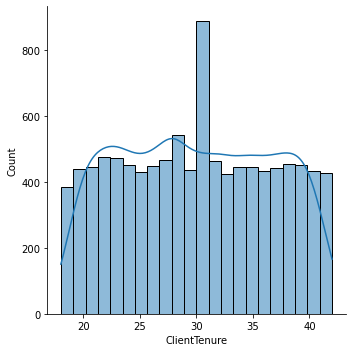

In [140]:
##plot client tenure
sns.displot(data= dataset_preprocess, x='ClientTenure', kde=True)
plt.show()

## there a spike at 30 years of tenure, we only had 17 missing values so it couldn't be from imputation

<AxesSubplot:xlabel='MonthSal', ylabel='Count'>

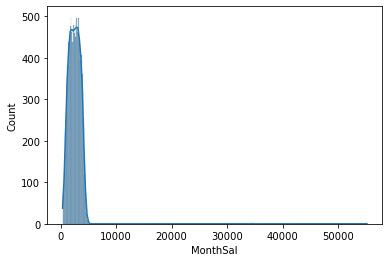

In [141]:
## Monthly salary
sns.histplot(data= dataset_preprocess, x='MonthSal', kde=True)

## huge right tale, lets see the outliers

In [142]:
dataset_preprocess['MothSalZscore'] = (dataset_preprocess['MonthSal'] - dataset_preprocess['MonthSal'].mean())/dataset_preprocess['MonthSal'].std(ddof=0)

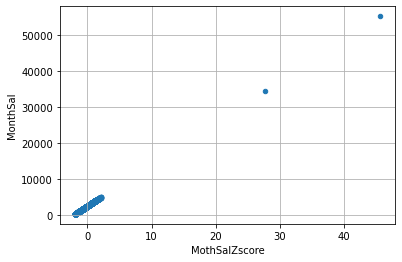

In [143]:
dataset_preprocess.plot.scatter(x='MothSalZscore', y='MonthSal', grid=True)
plt.show()

In [144]:
## lets remove these 2 observations 
dataset_outliers = dataset_preprocess.loc[dataset_preprocess['MonthSal']<10000]

In [145]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.63 of the original data


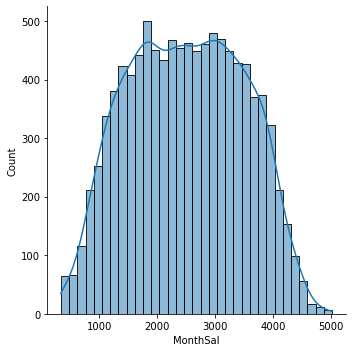

In [146]:
## plot the distribution of monthly salary
sns.displot(data= dataset_outliers, x='MonthSal', kde=True)
plt.show()

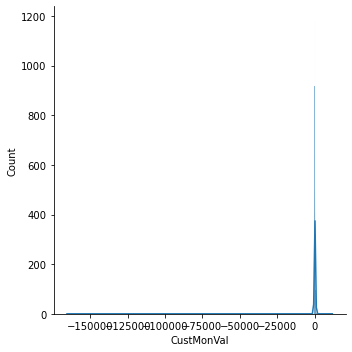

In [147]:
## Customer LTV
sns.displot(data= dataset_outliers, x='CustMonVal', kde=True)
plt.show()

In [148]:
dataset_outliers['CustMonValZscore'] = (dataset_outliers['CustMonVal'] - dataset_outliers['CustMonVal'].mean())/dataset_outliers['CustMonVal'].std(ddof=0)

<ipython-input-148-a017bc8e67db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_outliers['CustMonValZscore'] = (dataset_outliers['CustMonVal'] - dataset_outliers['CustMonVal'].mean())/dataset_outliers['CustMonVal'].std(ddof=0)


<AxesSubplot:xlabel='CustMonValZscore', ylabel='CustMonVal'>

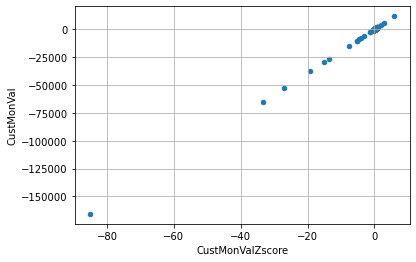

In [149]:
dataset_outliers.plot.scatter(x='CustMonValZscore', y='CustMonVal', grid=True)

In [150]:
## lets remove these observations
dataset_outliers = dataset_outliers.loc[dataset_outliers['CustMonVal']>-10000]

In [151]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.54 of the original data


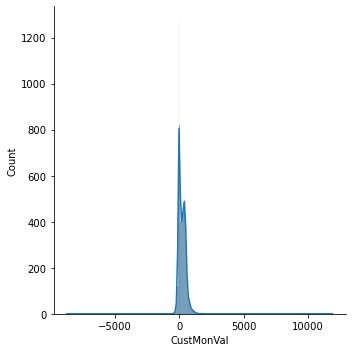

In [152]:
sns.displot(data= dataset_outliers, x='CustMonVal', kde=True)
plt.show()

We still have long tailes here lets plot again the zscores

<AxesSubplot:xlabel='CustMonVal', ylabel='CustMonValZscore'>

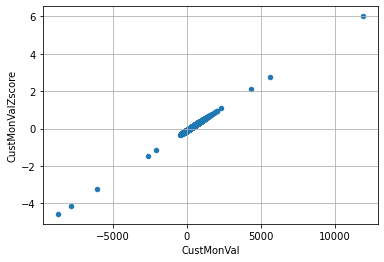

In [153]:
dataset_outliers.plot.scatter(x='CustMonVal', y='CustMonValZscore', grid=True)

In [154]:
## it seems we still have outliers, lets keep only clients with LTV beteween -2k and + 2k
dataset_outliers = dataset_outliers.loc[(dataset_outliers['CustMonVal']>-2000) & (dataset_outliers['CustMonVal']<1500)]

In [155]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.38 of the original data


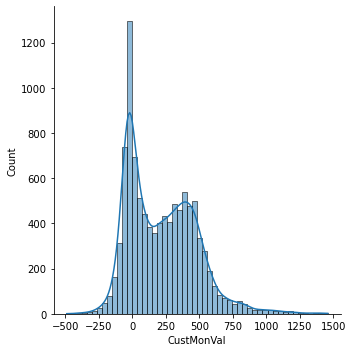

In [156]:
sns.displot(data= dataset_outliers, x='CustMonVal', kde=True)

we have two modes in the variable, we may want to do some transformation here - remember we have negative values so no logs!

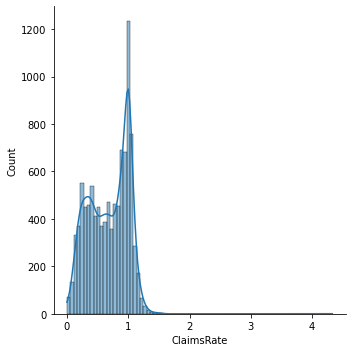

In [157]:
## Claims Rate
sns.displot(data= dataset_outliers, x='ClaimsRate', kde=True)

In [158]:
# There are 1 client with claims that represent 2 times their premiums in the last 24 months: these are really bad clients
len(dataset_outliers.loc[dataset_outliers['ClaimsRate']>=1.5])

6

In [159]:
#lets keep clients it claims rate < 2
dataset_outliers = dataset_outliers.loc[dataset_outliers['ClaimsRate']<=1.5]

In [160]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.33 of the original data


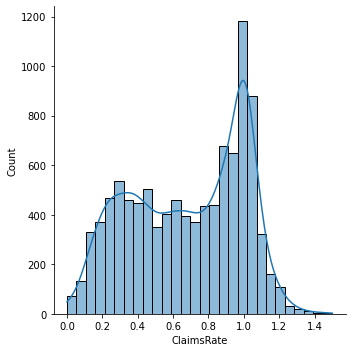

In [161]:
sns.displot(data= dataset_outliers, x='ClaimsRate', kde=True)

There is strangely a lot of clients with claim rate = 1 where the company has no margin

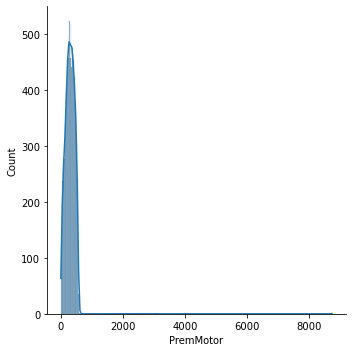

In [162]:
## Motor premium
sns.displot(data= dataset_outliers, x='PremMotor', kde=True)

In [163]:
dataset_outliers['PremMotorZscore'] = (dataset_outliers['PremMotor'] - dataset_outliers['PremMotor'].mean())/dataset_outliers['PremMotor'].std(ddof=0)

<AxesSubplot:xlabel='PremMotorZscore', ylabel='PremMotor'>

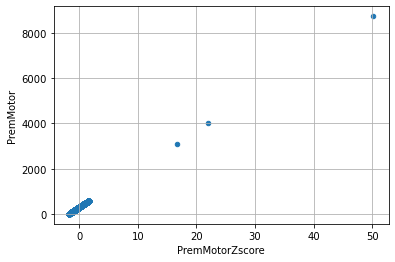

In [164]:
dataset_outliers.plot.scatter(x='PremMotorZscore', y='PremMotor', grid=True)

In [165]:
#lets keep clients it motor premiums < 2000
dataset_outliers = dataset_outliers.loc[dataset_outliers['PremMotor']<2000]

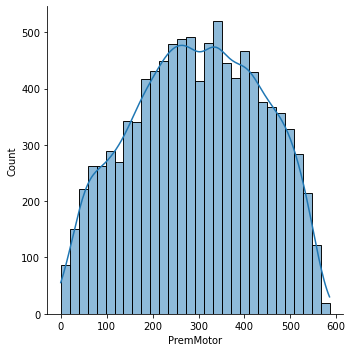

In [166]:
sns.displot(data= dataset_outliers, x='PremMotor', kde=True)

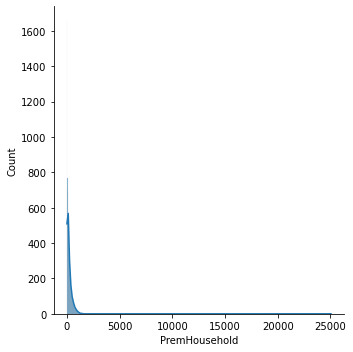

In [167]:
## Home Premiums
sns.displot(data= dataset_outliers, x='PremHousehold', kde=True)

In [168]:
dataset_outliers['PremHomeZscore'] = (dataset_outliers['PremHousehold'] - dataset_outliers['PremHousehold'].mean())/dataset_outliers['PremHousehold'].std(ddof=0)

<AxesSubplot:xlabel='PremHomeZscore', ylabel='PremHousehold'>

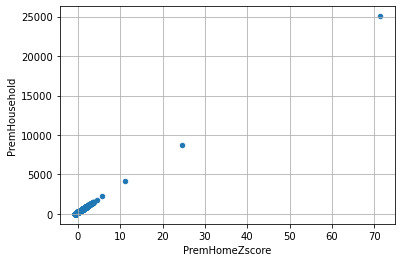

In [169]:
dataset_outliers.plot.scatter(x='PremHomeZscore', y='PremHousehold', grid=True)

In [170]:
#lets keep clients it motor premiums < 2000
dataset_outliers = dataset_outliers.loc[dataset_outliers['PremHousehold']<2000]

In [171]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.26 of the original data


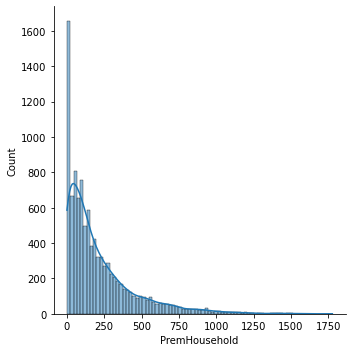

In [172]:
sns.displot(data= dataset_outliers, x='PremHousehold', kde=True)

A lot of clients with really smaill premiums. lets compute a graph for smaller premiums

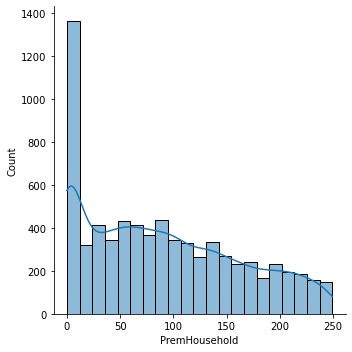

In [173]:
sns.displot(data= dataset_outliers.loc[dataset_outliers['PremHousehold']<250], x='PremHousehold', kde=True)

Its confirmed a lot of clients dont own Home insurance

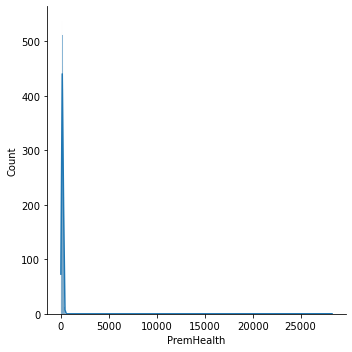

In [174]:
# Health insurance
sns.displot(data= dataset_outliers, x='PremHealth', kde=True)

<AxesSubplot:xlabel='PremHealthZscore', ylabel='PremHealth'>

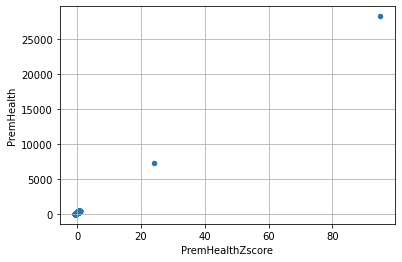

In [175]:
dataset_outliers['PremHealthZscore'] = (dataset_outliers['PremHealth'] - dataset_outliers['PremHealth'].mean())/dataset_outliers['PremHealth'].std(ddof=0)
dataset_outliers.plot.scatter(x='PremHealthZscore', y='PremHealth', grid=True)

In [176]:
#lets keep clients it motor premiums < 2000
dataset_outliers = dataset_outliers.loc[dataset_outliers['PremHealth']<5000]

In [177]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.24 of the original data


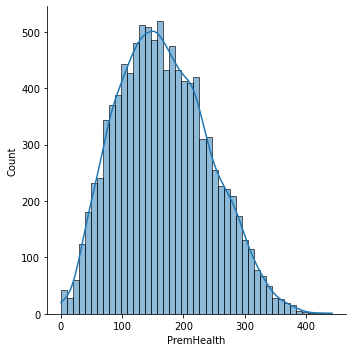

In [178]:
sns.displot(data= dataset_outliers, x='PremHealth', kde=True)

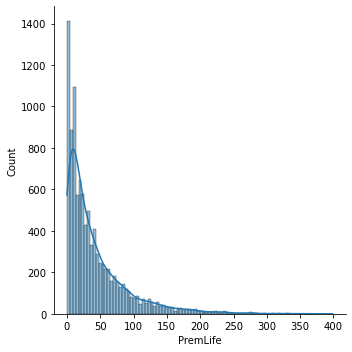

In [179]:
# Life Premiums
sns.displot(data= dataset_outliers, x='PremLife', kde=True)

<ipython-input-180-27259287c683>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_outliers['PremLifeZscore'] = (dataset_outliers['PremLife'] - dataset_outliers['PremLife'].mean())/dataset_outliers['PremLife'].std(ddof=0)


<AxesSubplot:xlabel='PremLifeZscore', ylabel='PremLife'>

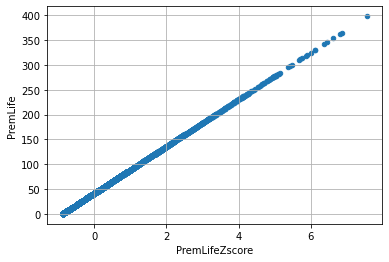

In [180]:
dataset_outliers['PremLifeZscore'] = (dataset_outliers['PremLife'] - dataset_outliers['PremLife'].mean())/dataset_outliers['PremLife'].std(ddof=0)
dataset_outliers.plot.scatter(x='PremLifeZscore', y='PremLife', grid=True)

There is no really outliers in this one, but probably we will need to transform

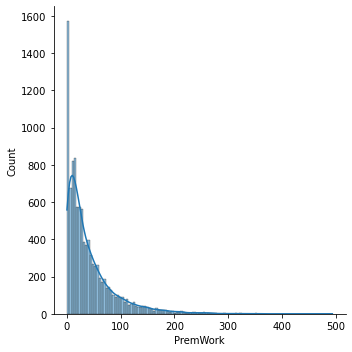

In [181]:
## Workers Comp 
sns.displot(data= dataset_outliers, x='PremWork', kde=True)

<ipython-input-182-90e9dc4b24b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_outliers['PremWorkZscore'] = (dataset_outliers['PremWork'] - dataset_outliers['PremWork'].mean())/dataset_outliers['PremWork'].std(ddof=0)


<AxesSubplot:xlabel='PremWorkZscore', ylabel='PremWork'>

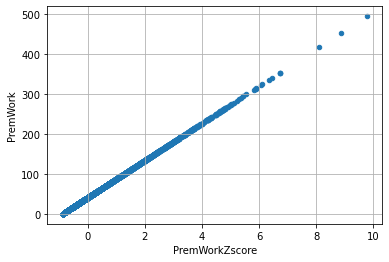

In [182]:
dataset_outliers['PremWorkZscore'] = (dataset_outliers['PremWork'] - dataset_outliers['PremWork'].mean())/dataset_outliers['PremWork'].std(ddof=0)
dataset_outliers.plot.scatter(x='PremWorkZscore', y='PremWork', grid=True)

In [183]:
#lets keep clients it motor premiums < 400
dataset_outliers = dataset_outliers.loc[dataset_outliers['PremWork']<400]

In [184]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.21 of the original data


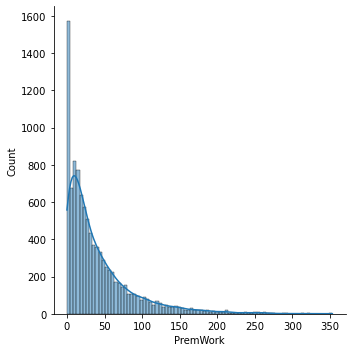

In [185]:
sns.displot(data= dataset_outliers, x='PremWork', kde=True)

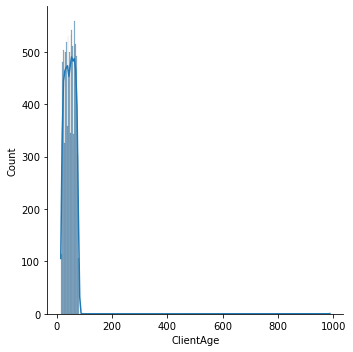

In [186]:
## Client Age
sns.displot(data= dataset_outliers, x='ClientAge', kde=True)

In [187]:
#lets keep clients with age < 100
dataset_outliers = dataset_outliers.loc[dataset_outliers['ClientAge']<100]

In [188]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 99.20 of the original data


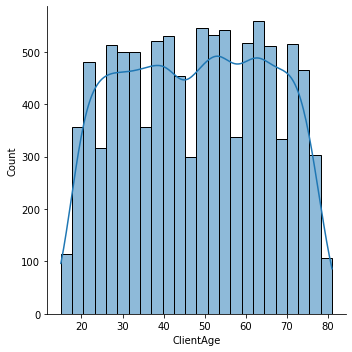

In [189]:
sns.displot(data= dataset_outliers, x='ClientAge', kde=True)

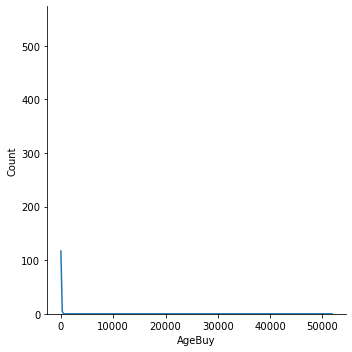

In [190]:
## Age that a client bougth is first policy
sns.displot(data= dataset_outliers, x='AgeBuy', kde=True)

In [191]:
## replace outlier with mode
dataset_outliers.AgeBuy.replace(51836, np.median(dataset_outliers['AgeBuy']), inplace = True)

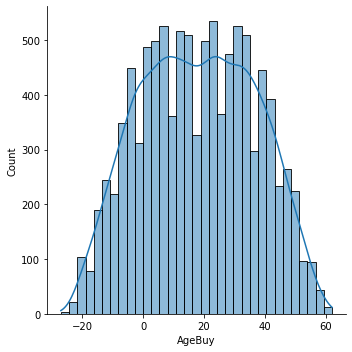

In [192]:
sns.displot(data= dataset_outliers, x='AgeBuy', kde=True)

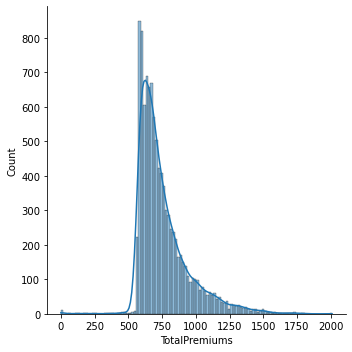

In [193]:
## Total premiums
sns.displot(data= dataset_outliers, x='TotalPremiums', kde=True)

We have seen before we had clients with no premiums. have remove them

In [194]:
#lets keep clients it total premiums> 0
dataset_outliers = dataset_outliers.loc[dataset_outliers['TotalPremiums']>0]

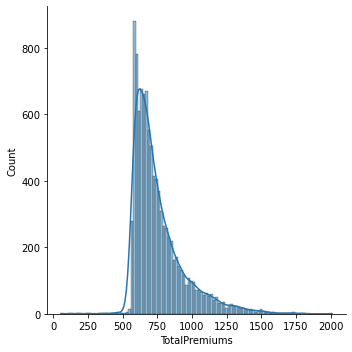

In [195]:
## Total premiums
sns.displot(data= dataset_outliers, x='TotalPremiums', kde=True)

<AxesSubplot:xlabel='TotalPremiumsZscore', ylabel='TotalPremiums'>

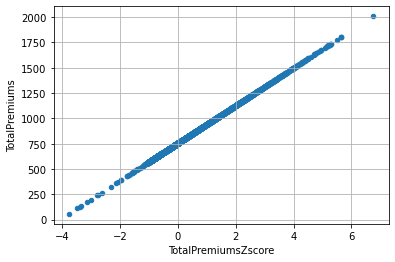

In [196]:
dataset_outliers['TotalPremiumsZscore'] = (dataset_outliers['TotalPremiums'] - dataset_outliers['TotalPremiums'].mean())/dataset_outliers['TotalPremiums'].std(ddof=0)
dataset_outliers.plot.scatter(x='TotalPremiumsZscore', y='TotalPremiums', grid=True)

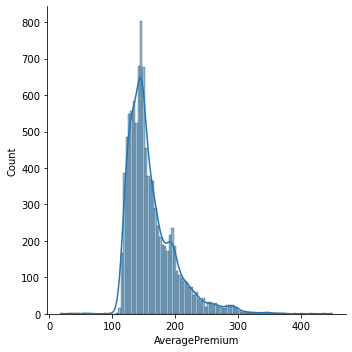

In [197]:
## Average Premium
sns.displot(data= dataset_outliers, x='AveragePremium', kde=True)

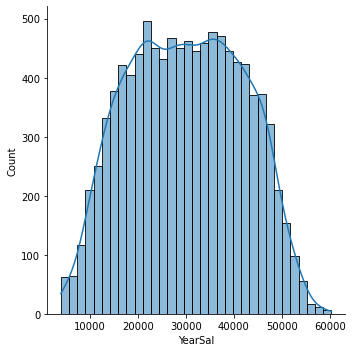

In [198]:
## Year salary
sns.displot(data= dataset_outliers, x='YearSal', kde=True)

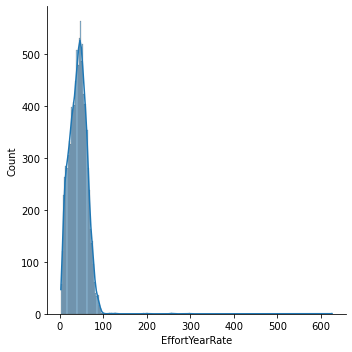

In [199]:
sns.displot(data= dataset_outliers, x='EffortYearRate', kde=True)

There is clients that are clearly over their head. paying 6 times in premiums that they earn per year

<AxesSubplot:xlabel='EffortZscore', ylabel='EffortYearRate'>

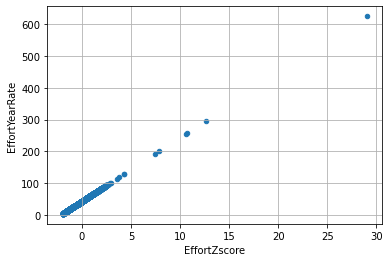

In [200]:
dataset_outliers['EffortZscore'] = (dataset_outliers['EffortYearRate'] - dataset_outliers['EffortYearRate'].mean())/dataset_outliers['EffortYearRate'].std(ddof=0)
dataset_outliers.plot.scatter(x='EffortZscore', y='EffortYearRate', grid=True)

In [201]:
#lets keep clients with total effort <= 1
dataset_outliers = dataset_outliers.loc[dataset_outliers['EffortYearRate']<=100]

In [202]:
print('we kept {:.2f} of the original data'.format((len(dataset_outliers)/len(dataset))*100))

we kept 98.98 of the original data


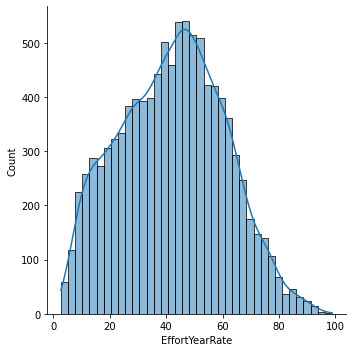

In [203]:
sns.displot(data= dataset_outliers, x='EffortYearRate', kde=True)

In [204]:
## new descriptive
# describe the dataset to try to find incoerences
dataset_outliers.describe().T.to_excel('DataDescription_Outliers.xlsx')

Center the data

In [205]:
dataset_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10188 entries, 0 to 10295
Data columns (total 44 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MonthSal             10188 non-null  float64
 1   Children             10188 non-null  float64
 2   CustMonVal           10188 non-null  float64
 3   ClaimsRate           10188 non-null  float64
 4   PremMotor            10188 non-null  float64
 5   PremHousehold        10188 non-null  float64
 6   PremHealth           10188 non-null  float64
 7   PremLife             10188 non-null  float64
 8   PremWork             10188 non-null  float64
 9   ClientTenure         10188 non-null  float64
 10  ClientAge            10188 non-null  float64
 11  AgeBuy               10188 non-null  float64
 12  HasMotor             10188 non-null  int32  
 13  HasHome              10188 non-null  int32  
 14  HasHealth            10188 non-null  int32  
 15  HasLife              10188 non-null 

In [206]:
dataset_filter = dataset_outliers.drop(columns=['ClientAge','AgeBuy','EffortYearRate','ClaimsRate','PremMotorProp','TotalPremiums','PremHouseholdProp','IsEquiped','PremLifeProp',
    'HasMotor','MotorReturns','HealthReturns','HasHealth','YearSal','PremHealthProp','PremWorkProp','HouseReturns','LifeReturns','WorkReturns','TotalReturns','HasReturns', 'ClientTenure'])

In [207]:
scaler = StandardScaler()
scaler.fit(dataset_filter)
dataset_scaled = pd.DataFrame(scaler.transform(dataset_filter), columns=dataset_filter.columns, index=dataset_filter.index)

In [208]:
dataset_scaled.head()

,MonthSal,Children,CustMonVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,HasHome,HasLife,...,AveragePremium,MothSalZscore,CustMonValZscore,PremMotorZscore,PremHomeZscore,PremHealthZscore,PremLifeZscore,PremWorkZscore,TotalPremiumsZscore,EffortZscore
0,-0.328141,0.643137,0.638488,0.570047,-0.568794,-0.284973,0.113070,-0.524223,0.350736,0.282505,...,-0.749979,-0.328141,0.638488,0.570047,-0.568794,-0.284973,0.113070,-0.524223,-0.493333,-0.154779
1,-1.853739,0.643137,-1.370435,-1.591445,0.906349,-0.683035,3.235470,1.422547,0.350736,0.282505,...,0.539243,-1.853739,-1.370435,-1.591445,0.906349,-0.683035,3.235470,1.422547,0.835829,-1.782283
2,-0.226435,-1.554878,1.123752,-0.659234,0.066602,-0.577180,0.946021,1.267443,0.350736,0.282505,...,-0.355753,-0.226435,1.123752,-0.659234,0.066602,-0.577180,0.946021,1.267443,-0.086893,-0.281229
3,-1.424537,0.643137,-0.922674,-0.830696,-0.726931,1.926172,-0.134020,-0.274441,0.350736,0.282505,...,-1.090830,-1.424537,-0.922674,-0.830696,-0.726931,1.926172,-0.134020,-0.274441,-0.844744,-1.082788
4,-0.749206,0.643137,-0.717820,0.300359,-0.707438,0.201101,-0.484647,0.011554,0.350736,0.282505,...,-0.940789,-0.749206,-0.717820,0.300359,-0.707438,0.201101,-0.484647,0.011554,-0.690054,-0.456835


Check correlation to remove very correlated variables

In [209]:
dataset_scaled.corr(method='spearman').to_excel('../outputs/Correlation.xlsx')

Start applying alghoritms.

Lets start by fitting a k-means with cluster from 1 to 10 and check what is the optimal number of clusters

In [210]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}

In [211]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataset_scaled)
    sse.append(kmeans.inertia_)

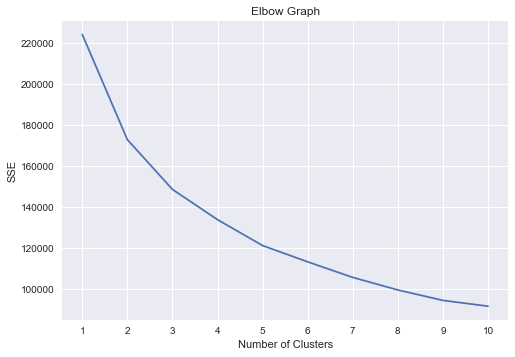

In [212]:
plt.style.use("seaborn")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.title('Elbow Graph')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

Looks like its 3 but lets confirm:

In [213]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

NameError: name 'KneeLocator' is not defined

In [214]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dataset_scaled)
    score = silhouette_score(dataset_scaled, kmeans.labels_)
    silhouette_coefficients.append(score)

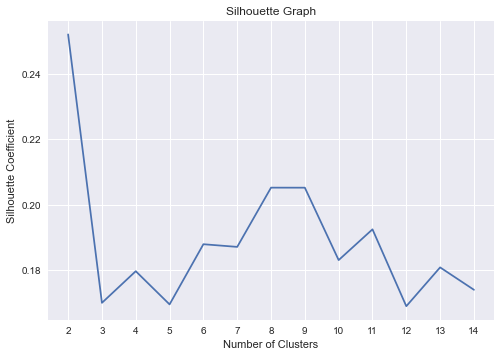

In [215]:
plt.style.use("seaborn")
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.title("Silhouette Graph")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

By the silhouette graph its clear that we shoud use 3 clusters

In [216]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, max_iter=300,random_state=42)

In [217]:
kmeans.fit(dataset_scaled)

KMeans(init='random', n_clusters=3, random_state=42)

In [218]:
# The lowest SSE value
kmeans.inertia_

148481.2199002717

In [219]:
# Final locations of the centroid
kmeans.cluster_centers_

array([[-0.8591625 , -0.00979566,  0.48103538, -1.26974838,  1.52617937,
        -0.00900276,  1.15971411,  1.1345986 ,  0.3339019 ,  0.22221721,
         0.25308611,  0.41969459,  1.26115755, -0.8591625 ,  0.48103538,
        -1.26974838,  1.52617937, -0.00900276,  1.15971411,  1.1345986 ,
         1.51237553, -1.20430117],
       [ 0.05992239,  0.39728663, -0.0234387 ,  1.05690489, -0.63068418,
        -0.8193561 , -0.60611991, -0.60940155, -0.489058  , -0.39007713,
        -0.44417803, -0.68914277, -0.24019628,  0.05992239, -0.0234387 ,
         1.05690489, -0.63068418, -0.8193561 , -0.60611991, -0.60940155,
        -0.62668897,  0.33261617],
       [ 0.30284576, -0.30168533, -0.17733924, -0.29745183, -0.13462269,
         0.63405152, -0.00468209,  0.0080434 ,  0.24065654,  0.2098635 ,
         0.23895017,  0.35975278, -0.32741714,  0.30284576, -0.17733924,
        -0.29745183, -0.13462269,  0.63405152, -0.00468209,  0.0080434 ,
        -0.13209009,  0.23321904]])

In [220]:
# The number of iterations required to converge
kmeans.n_iter_

27

In [221]:
kmeans.labels_

array([1, 0, 2, ..., 1, 2, 1])

In [222]:
from scipy import stats
stats.itemfreq(kmeans.labels_)

<ipython-input-222-aa0b3e9fec5e>:2: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  stats.itemfreq(kmeans.labels_)


array([[   0, 1901],
       [   1, 3601],
       [   2, 4686]], dtype=int64)

Lets try with another initiation technique

In [223]:
## adding the cluster to the dataframe
dataset_cluster = pd.concat([dataset_filter, pd.Series(kmeans.labels_,name='ClusterID', index=dataset_scaled.index)], axis=1)

In [224]:
dataset_cluster.groupby('ClusterID').agg('mean').T

ClusterID,0,1,2
MonthSal,1654.864282,2558.454041,2797.139351
Children,0.702788,0.888087,0.570423
CustMonVal,341.023645,212.256659,172.965220
PremMotor,121.843409,443.096090,256.127311
PremHousehold,557.749158,65.315607,178.579834
PremHealth,166.878096,106.493169,214.852580
PremLife,96.471142,13.045751,41.434434
PremWork,92.959190,12.983568,41.277766
HasHome,0.994740,0.737573,0.965642
HasLife,0.984219,0.823938,0.981007
